![Banner](img/AI_Special_Program_Banner.jpg)

## Recurrent Neural Networks (RNN) - Material 2: Sentiment Analysis
---

The material presented is adapted from *Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019 (code available on [GitHub](https://github.com/rasbt/python-machine-learning-book-3rd-edition)).

### Overview
---

 - [Example: Sentiment analysis of movie reviews](#Example:-Sentiment-analysis-of-movie-reviews)
     - [Preprocessing](#Preprocessing)
     - [Data Representation](#Data-Representation)
     - [Padding](#Padding)
     - [Embedding layers for sentence encoding](#Embedding-layers-for-sentence-encoding)
 - [General RNN structure using PyTorch](#General-RNN-structure-using-PyTorch)
 - [RNN for sentiment analysis](#RNN-for-sentiment-analysis)
 - [Visualization of embeddings](#Visualization-of-embeddings)

$\rightarrow$ &nbsp; [Material 3: Text Generation using a Tiny Language Model](3.3.b_RNN_3_TLM.ipynb)

In [1]:
# ensure torchtext installed
try:
    import torchtext
except:
    print("Installing torchtext")
    !pip install torchtext   

In [2]:
import os
import gzip
import shutil

import numpy as np
import pandas as pd
import random
import collections
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import get_tokenizer
from torch import nn

import datetime as dt

In [3]:
# importing module for training loop
from train_loop import train, train_for_epochs, validate, plot_history

In [4]:
CUDA_AVAILABLE = torch.cuda.is_available()
print(f'CUDA_AVAILABLE = {CUDA_AVAILABLE}')

CUDA_AVAILABLE = True


In [5]:
# if possible, we want to make use of GPU computing
USE_ONLY_CPU = False

In [6]:
random.seed(42)     # python random generator
np.random.seed(42)  # numpy random generator

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

### Example: Sentiment analysis of movie reviews
---
* reading data as *external data* and transforming dataset for `PyTorch`
* also available as [TorchText Dataset](https://pytorch.org/text/stable/datasets.html#imdb)

In [7]:
df = pd.read_csv('data/movie_data.csv', encoding='utf-8')
df.tail()

,review,sentiment
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0
49999,I waited long to watch this movie. Also becaus...,1


#### Preprocessing

In [8]:
# Step 1: extract target and values

target = df.pop('sentiment')

values = df.pop('review')

target[0], values[0]

(1,
 'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich 

 * **tokenizer**
   * `torchtext.data.utils.get_tokenize`: https://pytorch.org/text/stable/data_utils.html

In [9]:
#setup a tokenizer
tokenizer_name = 'basic_english' 
tokenizer = get_tokenizer(tokenizer_name)
tokenizer("This is an example. The tokenizer splits each part into a separate token!")

['this',
 'is',
 'an',
 'example',
 '.',
 'the',
 'tokenizer',
 'splits',
 'each',
 'part',
 'into',
 'a',
 'separate',
 'token',
 '!']

 * **vocabulary**
   * `torchtext.vocab`: https://pytorch.org/text/stable/vocab.html

In [10]:
counter_obj = collections.Counter()

#building a vocab which maps each token to a id
for v in values:
    tokens = tokenizer(v)
    counter_obj.update(tokens)
            
vocab = torchtext.vocab.vocab(counter_obj, min_freq=1, specials=['<unk>'])
# set a default index for out of vocabulary tokens
vocab.set_default_index(-1)
print('Vocab-size:', len(vocab))

Vocab-size: 147157


In [11]:
# the vocab can be used to lookup ids and tokens
vocab.lookup_token(100), vocab.lookup_indices(['good'])

('cover', [101])

In [12]:
test = 'And this is another Beispiel in Deutsch'
encoded = vocab.lookup_indices(tokenizer(test))
encoded

[33, 178, 46, 893, -1, 1, 38614]

As you can see, the German word `Beispiel` was not present in the text. Therefore, index -1 was assigned (`oov_token` index). Most interestingly, the term `Deutsch` has been used at least once in the reviews.

In [13]:
vocab.get_default_index()

-1

In [14]:
# define a function for transformation

def encode(value):
    return torch.tensor(vocab.lookup_indices(tokenizer(value)))

#### Data Representation

In [15]:
for i in range(5):
    example = encode(values[i])
    print('Sequence length:', len(example))
    
example

Sequence length: 273
Sequence length: 278
Sequence length: 340
Sequence length: 83
Sequence length: 130


tensor([150, 430, 431,   4, 267,   3, 432, 202, 130, 395, 150, 433,   4, 103,
        308,  16,  47, 434, 435,  21, 436, 437,   4, 334, 438, 196,  13,   4,
        105, 439,  21, 110, 440,   4, 441, 331, 149, 442,   3,   4, 443, 444,
         16,   4, 422, 445, 218,   4, 446,  21, 222,  16,   4, 422, 447, 287,
        448, 209,  33, 449,  21,   4, 414,  92,  93, 450, 420, 451,   4, 443,
        452, 453, 454, 195,  46, 455,  13, 456,  92,  93, 457,  21,   4, 458,
        459,  46, 368, 460,  21,   4, 359, 236, 150, 182, 195,  47, 248,   3,
         46, 461,  47, 320,  16,   4, 379, 447, 287, 462, 128,  13, 280, 463,
        464,   4, 465,  92,  93, 344,  13, 466, 436, 467,  16, 468,  33, 469,
        218,  16, 195,  21])

#### Padding
* all inputs of a batch have to be of the same length
* padding (with zeros) necessary
* https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

In [16]:
## Take a small subset for demonstration
for i in range(5):
    example = encode(values[i])
    print('Individual size:', len(example))

## batching some example value
eaxmple_batch = torch.nn.utils.rnn.pad_sequence([encode(values[i]) for i in range(5)], batch_first=True)

for batch in eaxmple_batch:
    print('Dimension in batch:', batch.shape[0])

Individual size: 273
Individual size: 278
Individual size: 340
Individual size: 83
Individual size: 130
Dimension in batch: 340
Dimension in batch: 340
Dimension in batch: 340
Dimension in batch: 340
Dimension in batch: 340


In [17]:
eaxmple_batch[1]

tensor([148,  21,  21,  21, 149,  21,  21,  21, 150, 151, 152, 153, 154,  33,
         67, 155, 156, 157, 158,  16, 159,   1,  67, 160,  21, 161,  52, 162,
        163,  66,  67, 164, 165, 166, 167, 168,  33, 169, 170, 171,  47, 172,
        173,  21,  82,   3, 174,  46,  67, 175,  21, 176, 177,   3, 178,  28,
         47, 179, 103, 180, 150, 181, 182, 183,  13,   4, 184,  33,  33,   4,
        185,   3, 186, 153,   3,  55, 187, 119, 188,  13, 189, 190, 191, 178,
        192,   3, 193, 105, 180, 194,  16, 195, 196, 190,  33, 153, 197, 198,
         92, 199, 200, 195, 201,  33, 169,  28, 202, 157, 203,   4, 204, 205,
        206, 207, 208, 209,  13, 163,  33, 210, 163, 211, 195,  28, 212, 213,
        180, 150, 214,  92, 199, 215,  51, 216,  22, 178, 103,  28, 217, 218,
         16, 219,  55,   4, 220,   3, 221, 222, 223, 224,  21,  21,  21, 150,
         92, 225, 226, 166, 227, 160,  51, 228,  47, 229,  55, 230, 231, 180,
        178, 228, 194,   3, 232,   3, 233,   3, 234,   3, 235,  

#### Putting it all together: preprocessing
Here, in addition, we allow the sequences to be shortened, leaving only a certain number of characters *at the end* of the sequence. This is convenient for experimentation (and we will get back to that).

In [18]:
class ReviewDataset(Dataset):
    def __init__(self, target, values, max_seq_length=None):
        self.max_seq_length = max_seq_length
        self.target = target
        self.values = values
        # setup tokenizer
        tokenizer_name = 'basic_english' 
        self.tokenizer = get_tokenizer(tokenizer_name)
        # setup vocab
        counter_obj = collections.Counter()
        for v in values:
            tokens = self.tokenizer(v)
            if self.max_seq_length is not None:
                # use allowed number of tokens at the end
                tokens = tokens[-self.max_seq_length:]
            counter_obj.update(tokens)
        self.vocab = torchtext.vocab.vocab(counter_obj, min_freq=1, specials=['<unk>'])
        # set a default index for out of vocabulary tokens
        self.vocab.set_default_index(-1)
        
    def __encode(self, value):
        tokens = self.tokenizer(value)
        if self.max_seq_length is not None:
            tokens = tokens[-self.max_seq_length:]
        return torch.tensor(self.vocab.lookup_indices(tokens))
    
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        return self.__encode(self.values[idx]), torch.tensor(target[idx]).float()
    
dataset = ReviewDataset(target=target, values=values)
len(dataset), dataset[0]

(50000,
 (tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,   4,
           14,  15,  16,  17,  18,   3,  19,   3,  20,  21,  22,   4,  23,  24,
            3,  25,  16,  26,   3,  27,  28,  29,   1,   4,  30,  16,  31,  32,
           33,  31,  34,  35,  36,  21,  37,  38,  39,   3,   4,  40,  41,  42,
            8,  43,  44,  11,   3,  45,  46,  47,  48,  49,  50,  51,  52,  53,
            1,  54,  55,  56,   1,  57,  21,  58,  21,  59,  60,  33,  61,  13,
           62,   3,  63,  13,  64,   4,  65,  66,  67,  68,  69,  70,   8,  71,
           72,  11,  66,   4,  73,  16,  74,  47,  75,  21,   4,  76,  77,  33,
           78,  79,  80,  81,   3,  82,  66,   4,  83,  16,   4,  84,  50,  85,
           86,   8,  87,  88,  11,  51,  28,   1,  89,  16,   4,  90,   1,   4,
           91,  92,  93,   3,  94,  95,   4,  96,  33,  47,  97,  16,  98,  33,
           99,  13, 100,   4,  34,  21,  34,   1,  19,  46,  47, 101, 102, 103,
            3,  66,   4, 104, 10

In [19]:
# setup train test split
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [30000, 5000, 15000])
print(f'Len train set: {len(train_set)}')
print(f'Len val set: {len(val_set)}')
print(f'Len test set: {len(test_set)}')

Len train set: 30000
Len val set: 5000
Len test set: 15000


In [20]:
# setup data loader
def batch_and_pad(data):
    values = [d[0] for d in data]
    labels = [d[1].unsqueeze(0) for d in data]
    return torch.nn.utils.rnn.pad_sequence(values, batch_first=True), torch.stack(labels)
    
train_loader = DataLoader(train_set, batch_size=32, collate_fn=batch_and_pad)
val_loader = DataLoader(val_set, batch_size=32, collate_fn=batch_and_pad)
test_loader = DataLoader(test_set, batch_size=32, collate_fn=batch_and_pad)

### Building the RNN-model
---
#### Embedding layers for sentence encoding
+ One-hot encoding $\rightarrow$ curse of dimensionality
+ better approach:
  * *projection* of each word onto $d$-dimensional space
  * real values instead of integers
+ *similar words* are closer together $\rightarrow$ *semantic coding*
+ ***learnable***!
+ used as *input layer* 


 * `input_dim`: number of words + 1 (see image below)
 * `output_dim`: vector length (learned features)
 * `input_length`: length of (padded) sequence
    * e.g., `'This is an example' -> [0, 0, 0, 0, 0, 0, 3, 1, 8, 9]`   
   $\rightarrow$ input_length is 10
   

<img src="./img/16_10.png" width=700/>

In [21]:
# for demonstration
embedding = nn.Embedding(num_embeddings=20, embedding_dim=6, padding_idx=0)
embedding

Embedding(20, 6, padding_idx=0)

### Visualization of embeddings
* It is possible to visualize the embedding by reducing the dimensionality to 3 or 2 dimensions, which can then be analyzed visually. [Here](https://shairozsohail.medium.com/exploring-deep-embeddings-fa677f0e7c90) is an example where this was done with tensorboard and image data, and [here](https://towardsdatascience.com/how-to-visualize-text-embeddings-with-tensorboard-47e07e3a12fb) you can find one for text data with tensorflow.

### General RNN structure using PyTorch

* **Pytorch RNN layers:**
  * `torch.nn.RNN(input_size, hidden_size, num_layers, bidirectional=False)`
  * `torch.nn.LSTM(..)`
  * `torch.nn.GRU(..)`

### RNN for sentiment analysis

#### Putting it all together: Building a model for sentiment analysis
Here, we allow the choice of different RNN architectures simply by passing the appropriate parameters. In doing so, we also allow a multi-layer structure as well as bidirectionality. This together with convenient preprocessing (see above) makes experimentation easy.

In [22]:
embedding_dim = 20
# add one for the padding value
vocab_size = len(dataset.vocab)
NUM_EPOCHS = 5

In [23]:
## build the model

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_units, recurrent_type='RNN', bidirectional=False, n_recurrent_layers=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        if recurrent_type == 'RNN':
            self.rnn = nn.RNN(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        elif recurrent_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_units, batch_first=True, bidirectional=bidirectional, num_layers=n_recurrent_layers)
        self.fc1 = nn.Linear(hidden_units * 2 if bidirectional else hidden_units, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        self.num_directions = 2 if bidirectional else 1
        self.hidden_units = hidden_units
        self.recurrent_type = recurrent_type

    def forward(self, x):
        batch_size, seq_len = x.shape
        embedded = self.embedding(x)
        #lstm also returns the cell hidden state
        if self.recurrent_type == "LSTM":
            output, (hidden, cell_hidden) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        # Concatenate the final hidden states from both directions if bidirectional
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        x = self.fc1(hidden)
        x = self.relu(x)
        x = self.fc2(x)
        output = self.sigmoid(x)
        return output

model = RNNModel(vocab_size, embedding_dim, 10, recurrent_type='RNN', n_recurrent_layers=1)
model

RNNModel(
  (embedding): Embedding(147157, 20, padding_idx=0)
  (rnn): RNN(20, 10, batch_first=True)
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() and not USE_ONLY_CPU else "cpu")
print(f'Using {device} for training')

Using cuda for training


#### First try: SimpleRNN

In [25]:
rnn_type = 'RNN'

model = RNNModel(vocab_size, embedding_dim, 128, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
model

RNNModel(
  (embedding): Embedding(147157, 20, padding_idx=0)
  (rnn): RNN(20, 128, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [26]:
# Move the model weight to the desired device
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

start_train = dt.datetime.now()
print(f'{rnn_type} training started: {start_train}')
# run training
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion, binary=True)
finish_train = dt.datetime.now()
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

RNN training started: 2024-01-28 23:17:06.809786


  0%|          | 0/5 [00:00<?, ?it/s]

RNN training finished 2024-01-28 23:18:03.729507 (duration: 0:00:56.919721)


In [27]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. {test_accuracy:.2f}%')


Test Acc. 50.27%


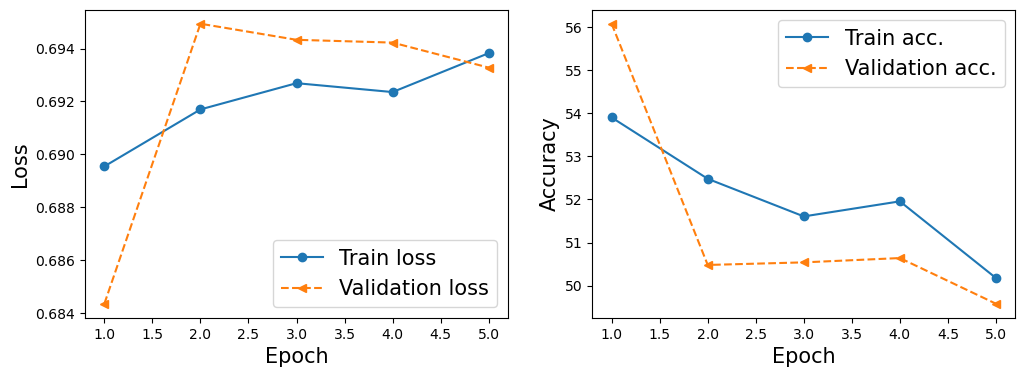

In [28]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)

plt.show()

Ok, this looks really bad! Hardly any progress after 5 epochs (and very erratic), so it seems, that `RNN` is not up to the task. Let us, therefore, try the more sophisticated LSTM.

#### Training the bidirectional LSTM

In [29]:
rnn_type = 'LSTM'
model = RNNModel(vocab_size, embedding_dim, 64, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
model

RNNModel(
  (embedding): Embedding(147157, 20, padding_idx=0)
  (rnn): LSTM(20, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [30]:
# Move the model weight to the desired device
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

start_train = dt.datetime.now()
print(f'{rnn_type} training started: {start_train}')
# run training
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion, binary=True)
finish_train = dt.datetime.now()
print(f'{rnn_type} training finished {finish_train} (duration: {finish_train - start_train})')

LSTM training started: 2024-01-28 23:18:08.043141


  0%|          | 0/5 [00:00<?, ?it/s]

LSTM training finished 2024-01-28 23:19:10.552577 (duration: 0:01:02.509436)


In [31]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. {test_accuracy:.2f}%')


Test Acc. 77.61%


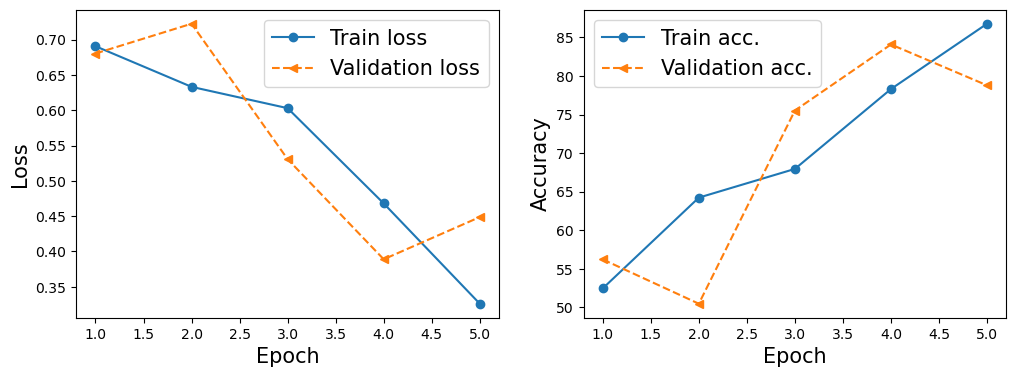

In [32]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)

plt.show()

Well, that is quite astounding, especially when you look at the validation accuracy after only a few epochs! So, the LSTM is much better for the task than SimpleRNN! Let us also keep this good model!

In [33]:
# if needed: save model
if not os.path.exists('models'):
    os.mkdir('models')

torch.save(model, f'models/Bidir-{rnn_type}-full-length-seq.pt')

### Simple RNN with Short Sequences

After discussing with a group of film lovers ($\equiv$ *domain experts*) we have a different idea: what if we gave `SimpleRNN` another shot with shorter sequences. The reasoning behind this approach is that in order to find the *sentiment* of a review, mostly the later part of what is written is the relevant one, since that is when people draw their conclusion respectively give their recommendation.

So, we have a different hyperparameter we need to decide on, namely `max_seq_length` in the dataset we defined above. Let us go for 40.

**Question**: What happened here if you bring it into context with CRISP-DM?

In [34]:
rnn_type = 'RNN'
batch_size = 32
embedding_dim = 20
max_seq_length = 40

# now we need to preprocess the data once more
dataset = ReviewDataset(target=target, values=values, max_seq_length=max_seq_length)
# setup train test split
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [30000, 5000, 15000])

train_loader = DataLoader(train_set, batch_size=32, collate_fn=batch_and_pad)
val_loader = DataLoader(val_set, batch_size=32, collate_fn=batch_and_pad)
test_loader = DataLoader(test_set, batch_size=32, collate_fn=batch_and_pad)

vocab_size = len(dataset.vocab)

model = RNNModel(vocab_size, embedding_dim, 64, recurrent_type=rnn_type, n_recurrent_layers=1, bidirectional=True)
model

RNNModel(
  (embedding): Embedding(52679, 20, padding_idx=0)
  (rnn): RNN(20, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [35]:
# Move the model weight to the desired device
model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

start_train = dt.datetime.now()
print(f'SimpleRNN training (short sequences) started: {start_train}')
# run training
history = train_for_epochs(device, NUM_EPOCHS, model, train_loader, val_loader, optimizer, criterion, binary=True)
finish_train = dt.datetime.now()
print(f'SimpleRNN training (short sequences) finished {finish_train} (duration: {finish_train - start_train})')

SimpleRNN training (short sequences) started: 2024-01-28 23:19:20.125468


  0%|          | 0/5 [00:00<?, ?it/s]

SimpleRNN training (short sequences) finished 2024-01-28 23:19:52.725576 (duration: 0:00:32.600108)


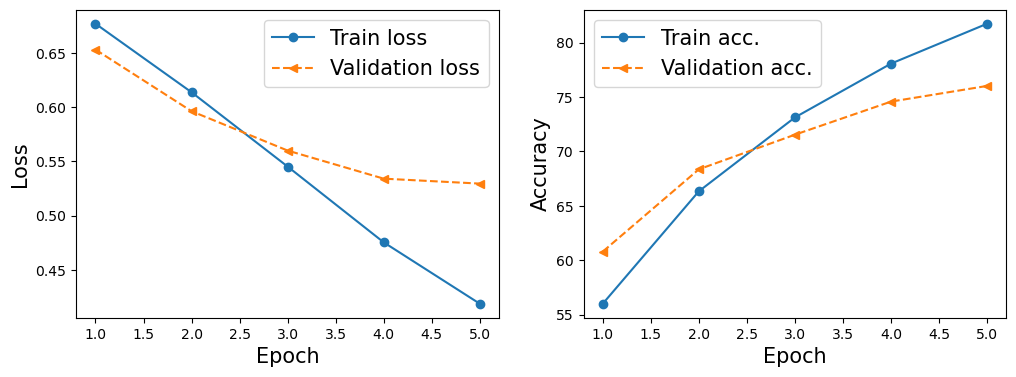

In [36]:
loss_train_hist = history['train']['loss']
acc_train_hist = history['train']['accuracy']
loss_val_hist = history['val']['loss']
acc_val_hist = history['val']['accuracy']

x_arr = np.arange(len(loss_train_hist)) + 1

plot_history(loss_train_hist, acc_train_hist, loss_val_hist, acc_val_hist)

plt.show()

In [37]:
## evaluate on the test data
test_loss, test_accuracy = validate(device, model, test_loader, criterion)
print(f'\nTest Acc. {test_accuracy:.2f}%')


Test Acc. 75.43%


So, it looks like a bit of feature engineering can sometimes be a good way of moving forward. While we still do not quite get the result of the sophisticated network, we were definitely able to make good progress even with an older approach. The training time is almost exactly the same and it even seems that we have found a promising model, since the validation accuracy is around 75%, as is the training accuracy, indicating a model which does not overfit and generalizes well enough (although, from looking at the training history, it looks like we are runnning into overfitting).

Maybe it would be a good idea to combine this feature engineering with the more sophisticated model ... Why not try this out yourself?

After seeing RNNs in action once, let us look at another fun example: [character-level training](3.3.b_RNN_3_TLM.ipynb)